<a href="https://colab.research.google.com/github/GrzegorzAndrzejczak/Programowanie-w-Pythonie/blob/main/CASE-lighthouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dane: lighthouse.csv

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings


np.random.seed(1)  # for repeatability
# Load the data on the recorded positions and plot their distribution as an histogram.
d = pd.read_csv('sample_data/lighthouse.csv')
N = 5  # number of measurements
D = d.values[:N]
print(D,f"średnio: {D.mean()}")

ndim = 2  # number of parameters in the model
nwalkers = 10000  # number of MCMC walkers
nburn = 500  # "burn-in" period to let chains stabilize
nsteps = 10000  # number of MCMC steps to take - czyli zostaje 200:10000


def log_prior(a,b):
    mask = b<=0
    b[mask] = 0
    result = -b**(-1)
    # result[mask] = -np.inf
    return result  #   //flat prior, składnik 1/b odsuwa od b=0


def log_likelihood(a, b, Data):
    mask = b<=0
    b[mask] = 0
    result = -np.sum(np.log((Data - a)**2 + b**2)-np.log(b), axis=0)

    # result[mask] = -np.inf
    return result


def log_posterior(a, b, Data):
    warnings.simplefilter("ignore")
    return log_prior(a, b) + log_likelihood(a, b, Data)


def compute_log_prob(coords):
    """Calculate the vector of log-probability for the walkers
    Args:
      coords: (ndarray[..., ndim]) The position vector in parameter
          space where the probability should be calculated.
    """
    log_prob = np.array([log_posterior(*p, D) for p in coords])
    # to będzie spowalniać dla większego rozmiaru próbek - nwalkers
    return log_prob



[[ 31.04551878]
 [ 39.15193522]
 [  1.81317194]
 [-10.04647801]
 [ -2.2359284 ]] średnio: 11.945643906451632


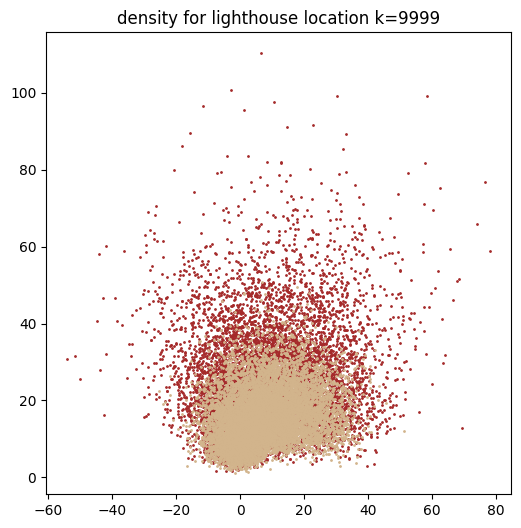

In [4]:
paths = np.empty((nsteps, nwalkers, ndim), dtype = np.float32)
np.random.seed(123)
ab = np.random.rand(nwalkers,ndim)*20
log_post = log_posterior(*ab.T, D)

for k_ in range(nsteps):
    # ab_ = ab + np.random.randn(nwalkers,ndim)/10     # ok. 0.245...0.18...
    ab_ = ab + np.random.randn(nwalkers,ndim)/3     # !!! był DUŻY BŁĄD: (ndim) - a przecież
                                                    #   każda para zmienia się indywidualnie!
    log_post_ = log_posterior(*ab_.T, D)
    H_ = log_post_ - log_post
    u_ = np.log(np.random.uniform(size=nwalkers))
    where = u_ < H_
    # ab = ab.copy()
    ab[where] = ab_[where]
    # log_post = log_post.copy()
    log_post[where] = log_post_[where]
    paths[k_] = ab

_, axn = plt.subplots(1, 1, figsize=(6, 6))
axn.scatter(*paths[k_].T, s=1, c="brown")
axn.scatter(*paths[k_//10].T, s=1, c="tan")
# axs.set_aspect(1)
axn.set_title(f"density for lighthouse location k={k_}")
plt.show(block=False)


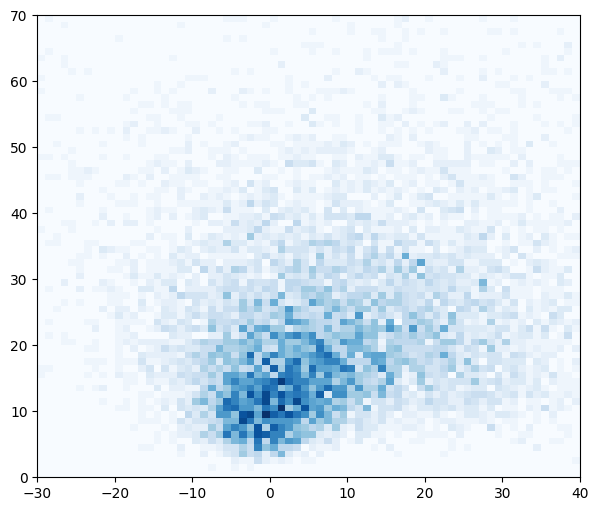

In [7]:
path = paths[-1]
Hb, xb, yb = np.histogram2d(*path.T, bins=140, density=True, range=np.asarray([[-70,70],[0,140]]))    # density=True,
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
Xb, Yb = np.meshgrid(xb, yb)
ax.set_xlim(-30,40);
ax.set_ylim(0,70);
ax.pcolormesh(Xb, Yb, Hb.T, cmap="Blues")
# cntr = ax.tricontourf(*path.T, Hb, levels=15, cmap="RdBu_r")
# fig.colorbar(cntr, ax=ax)

